In [1]:
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


tsai       : 0.2.15
fastai     : 2.2.5
fastcore   : 1.3.19
torch      : 1.7.1+cu101


# 0. load data

In [2]:
input_fn = 'F:\\Github\\kaggle drought\\data_ndarray.npz'

In [3]:
data = np.load(open(input_fn, 'rb'))

In [4]:
X_train = data['X_train']

In [5]:
X_train.shape

(118024, 90, 18)

In [6]:
print(np.mean(X_train.flatten()))

1.1619668e-07


In [7]:
print(np.std(X_train.flatten()))

1.0000005


In [8]:
X_valid = data['X_valid']

In [9]:
X_test = data['X_test']

In [10]:
y_train = data['y_train']
y_train = np.array([int(i) for i in y_train])

In [11]:
y_valid = data['y_valid']
y_valid = np.array([int(i) for i in y_valid])

In [12]:
y_test = data['y_test']
y_test = np.array([int(i) for i in y_test])

We need to exchange two axes：
* **number of samples**
* **number of features** (aka variables, dimensions, channels)
* **number of steps** (or length, time steps, sequence steps)

In [13]:
X_train = X_train.transpose(0, 2, 1)
X_train.shape

(118024, 18, 90)

In [14]:
X_valid = X_valid.transpose(0, 2, 1)
X_valid.shape

(20721, 18, 90)

In [15]:
X_test = X_test.transpose(0, 2, 1)
X_test.shape

(102430, 18, 90)

We already have the split:

In [16]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [17]:
X.shape

(138745, 18, 90)

In [18]:
y.shape

(138745,)

In [19]:
splits

((#118024) [0,1,2,3,4,5,6,7,8,9...],
 (#20721) [118024,118025,118026,118027,118028,118029,118030,118031,118032,118033...])

In [20]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

(#138745) [(TSTensor(vars:18, len:90), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(1, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(1, dtype=torch.int32))...]

# 1. Model and Hyperparameter Tuning

In [21]:
import hyperopt
print(hyperopt.__version__)

0.2.5


In [22]:
from hyperopt import Trials, STATUS_OK, STATUS_FAIL, tpe, fmin, hp

In [23]:
search_space = {
    'batch_size': hp.choice('bs', [256, 512, 1024]),
    'time_steps': hp.choice('ts', [30, 60, 90]),  # lookback window size
    "lr": hp.choice('lr', [0.1, 0.01, 0.001, 0.0001]),
    "epochs": hp.choice('epochs', [10, 50, 100]),  # we would also use early stopping
    "patience": hp.choice('patience', [5, 10]),  # early stopping patience
    "optimizer": hp.choice('optimizer', [Adam, SGD, RMSProp])  # https://docs.fast.ai/optimizer
    # model parameters
}

In [24]:
search_space

{'batch_size': <hyperopt.pyll.base.Apply at 0x14bcea0b0c8>,
 'time_steps': <hyperopt.pyll.base.Apply at 0x14bcea0b708>,
 'lr': <hyperopt.pyll.base.Apply at 0x14bcea0be48>,
 'epochs': <hyperopt.pyll.base.Apply at 0x14bcea0d488>,
 'patience': <hyperopt.pyll.base.Apply at 0x14bcea0da08>,
 'optimizer': <hyperopt.pyll.base.Apply at 0x14bcea07048>}

In [25]:
X.shape

(138745, 18, 90)

In [26]:
time_steps = 30

In [27]:
X[:, :, -time_steps:].shape

(138745, 18, 30)

In [28]:
X_test[:, :, -time_steps:].shape

(102430, 18, 30)

In [29]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [30]:
import time
from fastai.callback.tracker import EarlyStoppingCallback

In [31]:
import gc

In [32]:
# clear memory 
gc.collect()

192

In [33]:
def create_model_hypopt(params):
    
    try:
        # clear memory 
        gc.collect()
        print("Trying params:",params)
        batch_size = params["batch_size"]
        time_steps = params["time_steps"]
    
        # Create data loader
        tfms  = [None, [Categorize()]]
        dsets = TSDatasets(X[:, :, -time_steps:], y, tfms=tfms, splits=splits, inplace=True)
        # set num_workers for memory bottleneck
        dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
        # Create model
        arch = ResNet
        k = {}
        model = create_model(arch, dls=dls, **k)
        print(model.__class__.__name__)
    
        # Training the model
        learn = Learner(dls, model, metrics=accuracy, opt_func=params['optimizer'])
        start = time.time()
        learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                            cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
        learn.plot_metrics()
        elapsed = time.time() - start
    
        vals = learn.recorder.values[-1]
        # vals[0], vals[1], vals[2]
        # train loss, valid loss, accuracy
        val_loss = vals[1]
    
        # delete tmp variables
        del dls
        del model
        del learn
        return {'loss': val_loss, 'status': STATUS_OK} # if accuracy use '-' sign, model is optional
    except:
        return {'loss': None, 'status': STATUS_FAIL}

Search the parameters:

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 100, 'lr': 0.0001, 'optimizer': <function Adam at 0x0000014B8E61E438>, 'patience': 5, 'time_steps': 60}
ResNet                                                                                                                 
  0%|                                                                           | 0/30 [00:29<?, ?trial/s, best loss=?]

epoch,train_loss,valid_loss,accuracy,time
0,1.760763,1.739570,0.243811,00:08
1,1.487081,1.479051,0.551277,00:06
2,1.258735,1.250489,0.610492,00:06
3,1.101603,1.106265,0.636021,00:06
4,1.003538,1.010406,0.651706,00:06
5,0.951765,0.963230,0.656677,00:06
6,0.906926,0.933615,0.665846,00:06
7,0.878827,0.917020,0.668983,00:06
8,0.857176,0.905761,0.672217,00:06
9,0.836615,0.911766,0.665508,00:07


No improvement since epoch 8: early stopping                                                                           
  0%|                                                                           | 0/30 [02:07<?, ?trial/s, best loss=?]

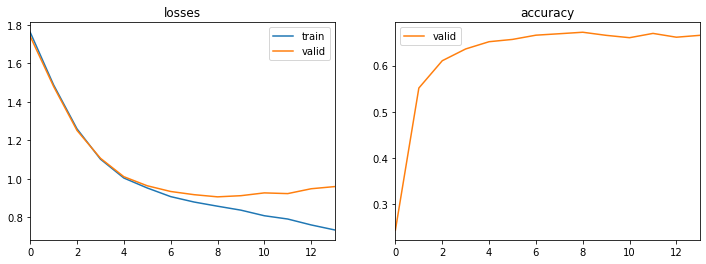

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 10, 'lr': 0.01, 'optimizer': <function Adam at 0x0000014B8E61E438>, 'patience': 10, 'time_steps': 60}
ResNet                                                                                                                 
  3%|█▌                                            | 1/30 [02:36<1:01:51, 127.98s/trial, best loss: 0.9589719176292419]

epoch,train_loss,valid_loss,accuracy,time
0,0.869396,0.950055,0.663192,00:06
1,0.779478,1.431708,0.656435,00:06
2,0.691539,1.106729,0.641620,00:06
3,0.619973,1.096975,0.667294,00:06
4,0.544075,1.187205,0.638579,00:06
5,0.474250,1.542868,0.615221,00:06
6,0.403490,1.485228,0.660682,00:06
7,0.330151,1.688322,0.638241,00:06
8,0.260786,1.926773,0.630037,00:06
9,0.226782,2.032445,0.620433,00:07


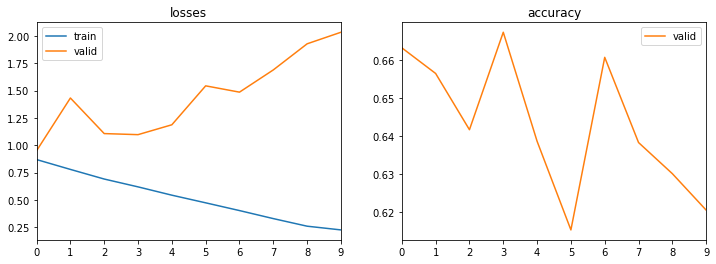

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 100, 'lr': 0.1, 'optimizer': <function Adam at 0x0000014B8E61E438>, 'patience': 10, 'time_steps': 30}
ResNet                                                                                                                 
  7%|███▏                                            | 2/30 [04:16<55:26, 118.81s/trial, best loss: 0.9589719176292419]

epoch,train_loss,valid_loss,accuracy,time
0,0.931626,0.945083,0.674195,00:04
1,0.891809,0.966962,0.668114,00:04
2,0.839108,1.010289,0.660682,00:04
3,0.794820,1.058087,0.663095,00:04
4,0.754531,1.044509,0.667391,00:04
5,0.726392,1.095056,0.659379,00:04
6,0.703139,1.239920,0.588244,00:04
7,0.682289,1.185796,0.659814,00:04
8,0.667686,1.222332,0.629603,00:04
9,0.648383,1.356771,0.640268,00:04


No improvement since epoch 0: early stopping                                                                           
  7%|███▏                                            | 2/30 [05:02<55:26, 118.81s/trial, best loss: 0.9589719176292419]

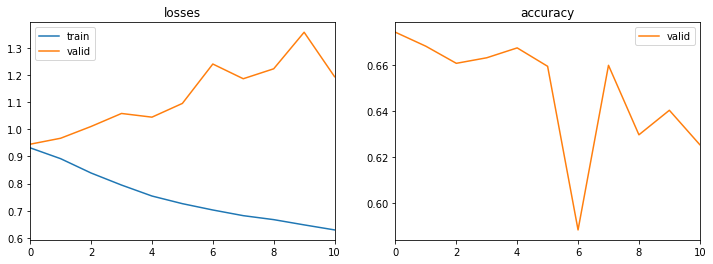

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 10, 'lr': 0.001, 'optimizer': <function Adam at 0x0000014B8E61E438>, 'patience': 5, 'time_steps': 60}
ResNet                                                                                                                 
 10%|████▊                                           | 3/30 [05:33<47:51, 106.35s/trial, best loss: 0.9589719176292419]

epoch,train_loss,valid_loss,accuracy,time
0,0.856668,0.904219,0.671589,00:08
1,0.711411,0.989482,0.630616,00:07
2,0.625124,1.270522,0.563004,00:07
3,0.537681,1.748407,0.654650,00:07
4,0.452500,1.252025,0.652719,00:08
5,0.383383,1.602496,0.624439,00:08


No improvement since epoch 0: early stopping                                                                           
 10%|████▊                                           | 3/30 [06:22<47:51, 106.35s/trial, best loss: 0.9589719176292419]

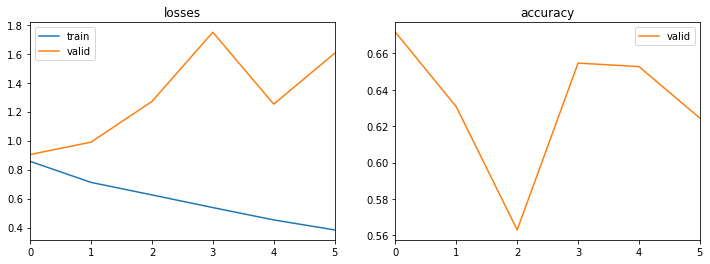

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 50, 'lr': 0.01, 'optimizer': <function RMSProp at 0x0000014B8E61E1F8>, 'patience': 5, 'time_steps': 60}
ResNet                                                                                                                 
 13%|██████▌                                          | 4/30 [06:51<42:37, 98.38s/trial, best loss: 0.9589719176292419]

epoch,train_loss,valid_loss,accuracy,time
0,0.799372,0.938373,0.677911,00:07
1,0.696592,1.077783,0.638193,00:07
2,0.681056,1.485803,0.664591,00:07
3,0.637529,2.011927,0.658269,00:07
4,0.608714,1.241994,0.656339,00:07
5,0.567995,1.404416,0.615656,00:07


No improvement since epoch 0: early stopping                                                                           
 13%|██████▌                                          | 4/30 [07:38<42:37, 98.38s/trial, best loss: 0.9589719176292419]

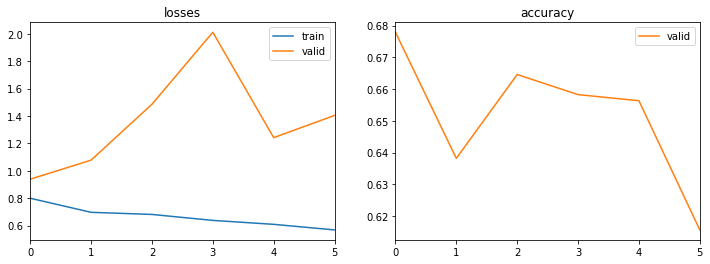

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 100, 'lr': 0.01, 'optimizer': <function Adam at 0x0000014B8E61E438>, 'patience': 10, 'time_steps': 30}
ResNet                                                                                                                 
 17%|████████▏                                        | 5/30 [08:07<38:16, 91.86s/trial, best loss: 0.9589719176292419]

epoch,train_loss,valid_loss,accuracy,time
0,0.874081,0.960126,0.678104,00:07
1,0.772358,1.210509,0.673713,00:07
2,0.694360,1.442506,0.670479,00:07
3,0.652007,1.245277,0.621495,00:07
4,0.616542,1.218592,0.641282,00:07
5,0.599471,1.445996,0.628300,00:07
6,0.605545,1.310552,0.582742,00:07
7,0.591455,1.302657,0.665750,00:07
8,0.589177,1.449192,0.660296,00:07
9,0.548346,1.978779,0.652189,00:07


No improvement since epoch 0: early stopping                                                                           
 17%|████████▏                                        | 5/30 [09:29<38:16, 91.86s/trial, best loss: 0.9589719176292419]

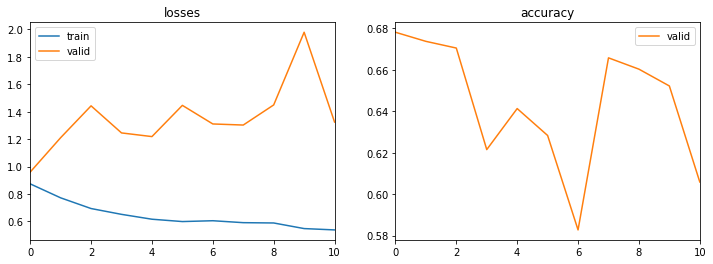

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 10, 'lr': 0.001, 'optimizer': <function Adam at 0x0000014B8E61E438>, 'patience': 5, 'time_steps': 60}
ResNet                                                                                                                 
 20%|█████████▊                                       | 6/30 [09:57<38:58, 97.45s/trial, best loss: 0.9589719176292419]

epoch,train_loss,valid_loss,accuracy,time
0,1.121433,0.971844,0.657449,00:06
1,0.887692,0.914912,0.680566,00:06
2,0.783556,1.046747,0.673568,00:06
3,0.689493,1.017221,0.675643,00:06
4,0.609060,1.187483,0.604314,00:06
5,0.538834,1.252346,0.661696,00:06
6,0.463915,1.147076,0.628879,00:06


No improvement since epoch 1: early stopping                                                                           
 20%|█████████▊                                       | 6/30 [10:42<38:58, 97.45s/trial, best loss: 0.9589719176292419]

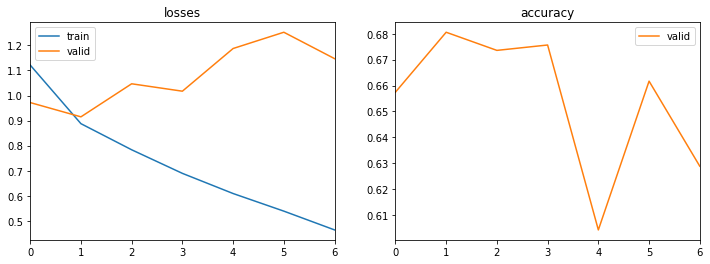

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 50, 'lr': 0.001, 'optimizer': <function RMSProp at 0x0000014B8E61E1F8>, 'patience': 10, 'time_steps': 30}
ResNet                                                                                                                 
 23%|███████████▍                                     | 7/30 [11:09<34:34, 90.20s/trial, best loss: 0.9589719176292419]

epoch,train_loss,valid_loss,accuracy,time
0,1.005488,0.988689,0.655470,00:03
1,0.937717,0.960528,0.671203,00:03
2,0.903727,1.076403,0.609913,00:03
3,0.874001,0.958070,0.670286,00:04
4,0.852684,1.016900,0.644708,00:04
5,0.824156,0.966745,0.670334,00:04
6,0.789204,1.147106,0.620240,00:03
7,0.748901,1.262960,0.632064,00:04
8,0.709880,1.230710,0.568409,00:04
9,0.654213,1.191340,0.654746,00:04


No improvement since epoch 3: early stopping                                                                           
 23%|███████████▍                                     | 7/30 [12:06<34:34, 90.20s/trial, best loss: 0.9589719176292419]

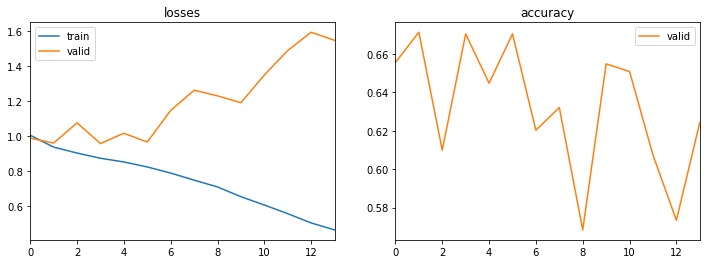

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 10, 'lr': 0.1, 'optimizer': <function Adam at 0x0000014B8E61E438>, 'patience': 10, 'time_steps': 60}
ResNet                                                                                                                 
 27%|█████████████                                    | 8/30 [12:31<32:19, 88.17s/trial, best loss: 0.9589719176292419]

epoch,train_loss,valid_loss,accuracy,time
0,0.890583,1.049882,0.663819,00:06
1,0.849960,1.052240,0.649438,00:06
2,0.797467,1.047914,0.664736,00:06
3,0.739920,1.231047,0.667970,00:06
4,0.682465,1.178900,0.673616,00:06
5,0.621032,1.142875,0.673134,00:06
6,0.564571,1.313246,0.662565,00:06
7,0.485704,1.402896,0.633560,00:06
8,0.405579,1.562373,0.615752,00:06
9,0.361644,1.645986,0.627431,00:06


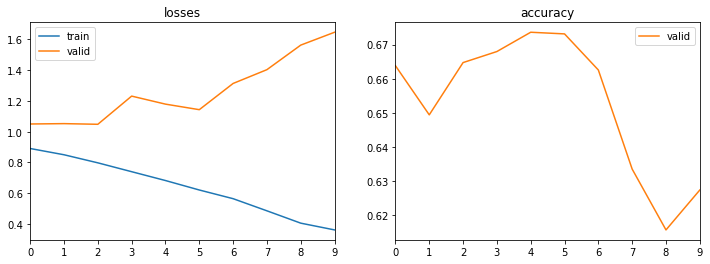

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 10, 'lr': 0.001, 'optimizer': <function RMSProp at 0x0000014B8E61E1F8>, 'patience': 5, 'time_steps': 60}
ResNet                                                                                                                 
 30%|██████████████▋                                  | 9/30 [14:04<31:21, 89.60s/trial, best loss: 0.9589719176292419]

epoch,train_loss,valid_loss,accuracy,time
0,1.023718,0.935986,0.668645,00:06
1,0.912552,0.973439,0.648859,00:06
2,0.862164,1.008263,0.665122,00:06
3,0.802827,0.929712,0.658849,00:06
4,0.736225,1.167862,0.582260,00:06
5,0.663011,0.995800,0.651609,00:06
6,0.589855,1.173231,0.621785,00:06
7,0.526134,1.117079,0.667728,00:06
8,0.482778,1.173320,0.662999,00:06


No improvement since epoch 3: early stopping                                                                           
 30%|██████████████▋                                  | 9/30 [15:01<31:21, 89.60s/trial, best loss: 0.9589719176292419]

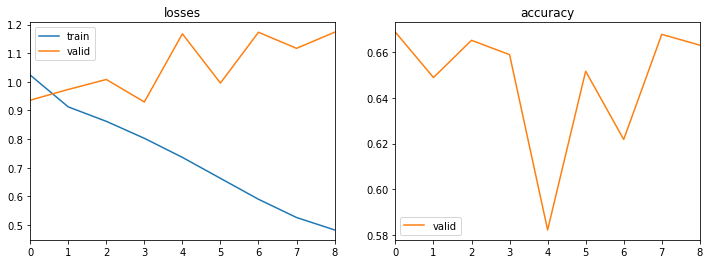

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 50, 'lr': 0.01, 'optimizer': <function SGD at 0x0000014B8E61E0D8>, 'patience': 5, 'time_steps': 30}
ResNet                                                                                                                 
 33%|████████████████                                | 10/30 [15:25<29:06, 87.33s/trial, best loss: 0.9589719176292419]

epoch,train_loss,valid_loss,accuracy,time
0,1.153471,1.104406,0.664447,00:05
1,1.066389,1.053920,0.661551,00:05
2,1.022813,1.017800,0.661213,00:05
3,0.985474,0.990019,0.660779,00:05
4,0.962465,0.975098,0.661648,00:05
5,0.948989,0.959775,0.663144,00:05
6,0.930022,0.949338,0.666860,00:05
7,0.909269,0.939217,0.673954,00:06
8,0.887861,0.948524,0.670383,00:06
9,0.880099,0.965857,0.673906,00:06


No improvement since epoch 7: early stopping                                                                           
 33%|████████████████                                | 10/30 [16:43<29:06, 87.33s/trial, best loss: 0.9589719176292419]

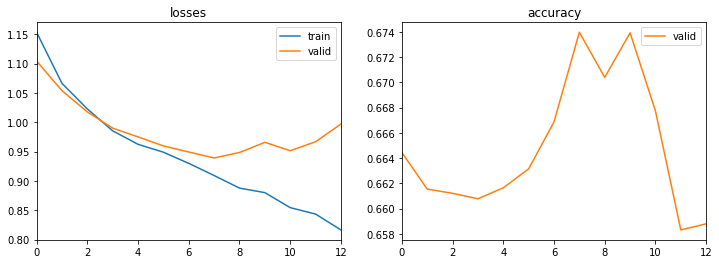

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 10, 'lr': 0.0001, 'optimizer': <function SGD at 0x0000014B8E61E0D8>, 'patience': 10, 'time_steps': 90}
ResNet                                                                                                                 
 37%|█████████████████▌                              | 11/30 [17:14<29:05, 91.87s/trial, best loss: 0.9589719176292419]

epoch,train_loss,valid_loss,accuracy,time
0,1.756485,1.752436,0.163506,00:09
1,1.705447,1.673382,0.226099,00:08
2,1.616998,1.574100,0.393659,00:08
3,1.533186,1.492775,0.498190,00:08
4,1.468804,1.434395,0.553448,00:08
5,1.424848,1.396175,0.592925,00:09
6,1.397305,1.372559,0.621399,00:08
7,1.380823,1.360973,0.632836,00:08
8,1.372587,1.355993,0.636118,00:08
9,1.371411,1.354315,0.636649,00:08


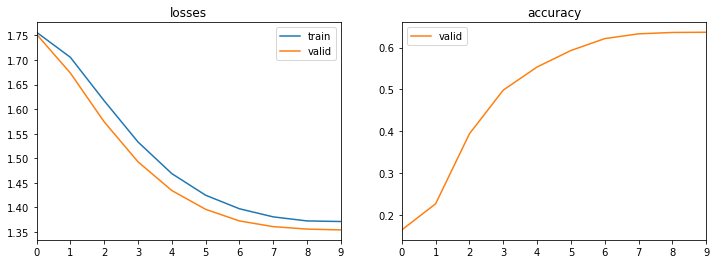

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 10, 'lr': 0.1, 'optimizer': <function Adam at 0x0000014B8E61E438>, 'patience': 5, 'time_steps': 30}
ResNet                                                                                                                 
 40%|██████████████████▊                            | 12/30 [19:09<30:08, 100.47s/trial, best loss: 0.9589719176292419]

epoch,train_loss,valid_loss,accuracy,time
0,0.948163,1.035517,0.639641,00:07
1,0.931771,0.951964,0.671058,00:07
2,0.900173,0.995081,0.676367,00:07
3,0.855211,0.963897,0.678056,00:07
4,0.822565,0.987214,0.665171,00:07
5,0.774892,1.113100,0.669514,00:07
6,0.714148,1.135873,0.671879,00:07


No improvement since epoch 1: early stopping                                                                           
 40%|██████████████████▊                            | 12/30 [19:59<30:08, 100.47s/trial, best loss: 0.9589719176292419]

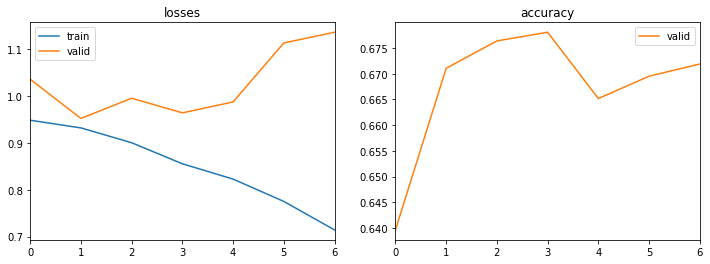

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 50, 'lr': 0.001, 'optimizer': <function SGD at 0x0000014B8E61E0D8>, 'patience': 5, 'time_steps': 60}
ResNet                                                                                                                 
 43%|████████████████████▊                           | 13/30 [20:24<26:19, 92.93s/trial, best loss: 0.9589719176292419]

epoch,train_loss,valid_loss,accuracy,time
0,1.709176,1.637597,0.376188,00:06
1,1.582487,1.503962,0.636504,00:06
2,1.434155,1.357836,0.664543,00:06
3,1.312244,1.244742,0.664543,00:06
4,1.217117,1.177372,0.664543,00:06
5,1.168292,1.140419,0.664543,00:06
6,1.120579,1.118576,0.664543,00:06
7,1.097291,1.101863,0.664543,00:06
8,1.071606,1.086179,0.664543,00:06
9,1.041002,1.068261,0.664591,00:06


No improvement since epoch 43: early stopping                                                                          
 43%|████████████████████▊                           | 13/30 [25:57<26:19, 92.93s/trial, best loss: 0.9589719176292419]

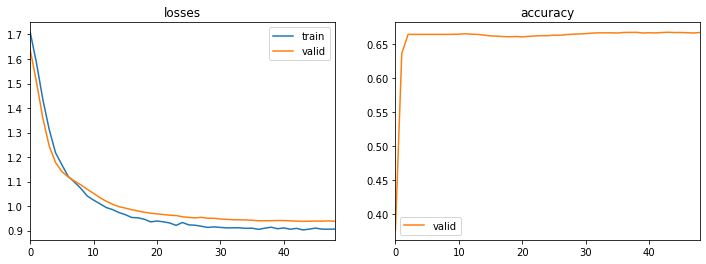

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 10, 'lr': 0.1, 'optimizer': <function SGD at 0x0000014B8E61E0D8>, 'patience': 5, 'time_steps': 90}
ResNet                                                                                                                 
 47%|██████████████████████▍                         | 14/30 [26:23<46:00, 172.55s/trial, best loss: 0.937955379486084]

epoch,train_loss,valid_loss,accuracy,time
0,0.955605,0.917478,0.661117,00:09
1,0.871742,0.872312,0.679600,00:09
2,0.809949,0.913656,0.665315,00:09
3,0.746216,0.912523,0.666618,00:09
4,0.684302,1.177724,0.655953,00:09
5,0.626677,1.095741,0.668404,00:09
6,0.571722,1.049437,0.677767,00:09


No improvement since epoch 1: early stopping                                                                           
 47%|██████████████████████▍                         | 14/30 [27:27<46:00, 172.55s/trial, best loss: 0.937955379486084]

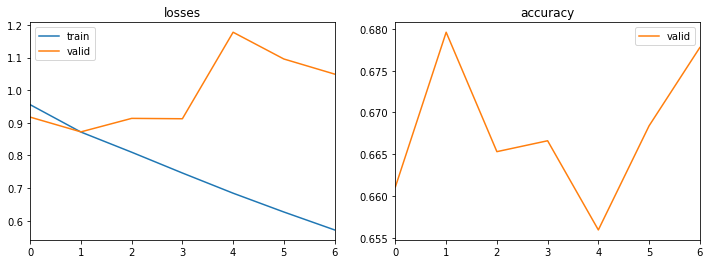

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 50, 'lr': 0.01, 'optimizer': <function RMSProp at 0x0000014B8E61E1F8>, 'patience': 10, 'time_steps': 30}
ResNet                                                                                                                 
 50%|████████████████████████                        | 15/30 [27:52<36:57, 147.81s/trial, best loss: 0.937955379486084]

epoch,train_loss,valid_loss,accuracy,time
0,0.878801,0.980866,0.672217,00:06
1,0.810006,1.181231,0.665315,00:06
2,0.764447,1.289639,0.648376,00:06
3,0.743106,1.076664,0.671300,00:06
4,0.711072,1.127776,0.665895,00:06
5,0.659507,1.221096,0.660248,00:06
6,0.624343,1.563692,0.660200,00:06
7,0.594860,1.619256,0.619758,00:06
8,0.555543,1.582477,0.647893,00:06
9,0.524229,1.491440,0.632933,00:06


No improvement since epoch 0: early stopping                                                                           
 50%|████████████████████████                        | 15/30 [29:01<36:57, 147.81s/trial, best loss: 0.937955379486084]

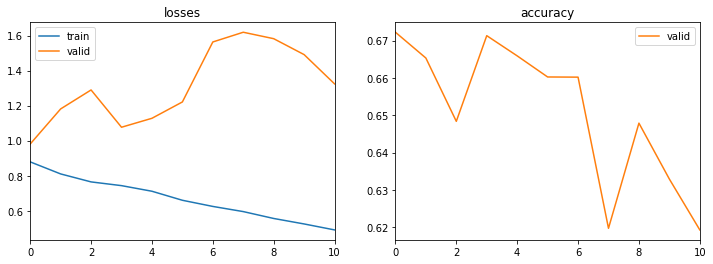

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 50, 'lr': 0.001, 'optimizer': <function RMSProp at 0x0000014B8E61E1F8>, 'patience': 5, 'time_steps': 60}
ResNet                                                                                                                 
 53%|█████████████████████████▌                      | 16/30 [29:26<30:40, 131.47s/trial, best loss: 0.937955379486084]

epoch,train_loss,valid_loss,accuracy,time
0,0.917151,0.952177,0.665895,00:07
1,0.845759,0.926557,0.668259,00:07
2,0.807144,1.056448,0.655374,00:07
3,0.759417,1.156848,0.656049,00:07
4,0.697359,1.191754,0.645915,00:07
5,0.632925,1.165749,0.666860,00:07
6,0.585388,1.472552,0.500748,00:07


No improvement since epoch 1: early stopping                                                                           
 53%|█████████████████████████▌                      | 16/30 [30:21<30:40, 131.47s/trial, best loss: 0.937955379486084]

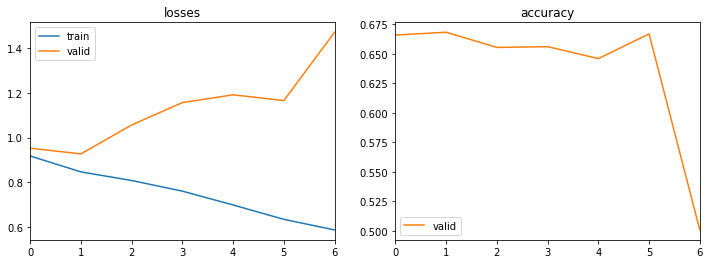

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 50, 'lr': 0.1, 'optimizer': <function RMSProp at 0x0000014B8E61E1F8>, 'patience': 10, 'time_steps': 30}
ResNet                                                                                                                 
 57%|███████████████████████████▏                    | 17/30 [30:46<25:07, 115.99s/trial, best loss: 0.937955379486084]

epoch,train_loss,valid_loss,accuracy,time
0,0.927646,0.966272,0.672410,00:06
1,0.884600,0.990887,0.657208,00:06
2,0.864303,1.047447,0.682882,00:06
3,0.819542,1.020485,0.678297,00:06
4,0.796640,1.373636,0.656435,00:06
5,0.788714,1.118147,0.645046,00:06
6,0.760984,1.351560,0.662372,00:06
7,0.746996,1.321277,0.667391,00:06
8,0.734462,1.156595,0.653395,00:06
9,0.701303,1.357270,0.529801,00:06


No improvement since epoch 0: early stopping                                                                           
 57%|███████████████████████████▏                    | 17/30 [31:54<25:07, 115.99s/trial, best loss: 0.937955379486084]

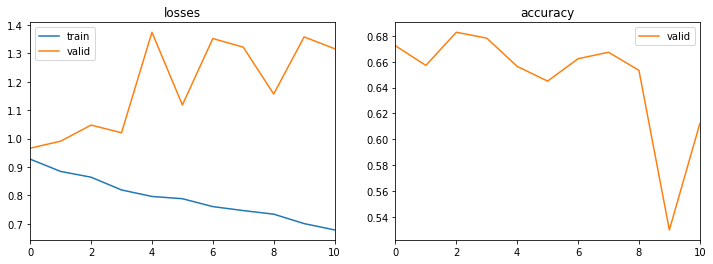

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 10, 'lr': 0.0001, 'optimizer': <function Adam at 0x0000014B8E61E438>, 'patience': 10, 'time_steps': 30}
ResNet                                                                                                                 
 60%|████████████████████████████▊                   | 18/30 [32:19<21:51, 109.31s/trial, best loss: 0.937955379486084]

epoch,train_loss,valid_loss,accuracy,time
0,1.290066,1.185117,0.616090,00:05
1,0.966687,0.977025,0.657256,00:04
2,0.902031,0.960209,0.668790,00:04
3,0.847570,0.972634,0.670721,00:04
4,0.806449,1.047444,0.662565,00:04
5,0.764058,0.997544,0.664495,00:04
6,0.735539,1.024567,0.667777,00:04
7,0.720591,1.016479,0.662758,00:04
8,0.706414,1.037506,0.661551,00:04
9,0.705392,1.033072,0.660827,00:04


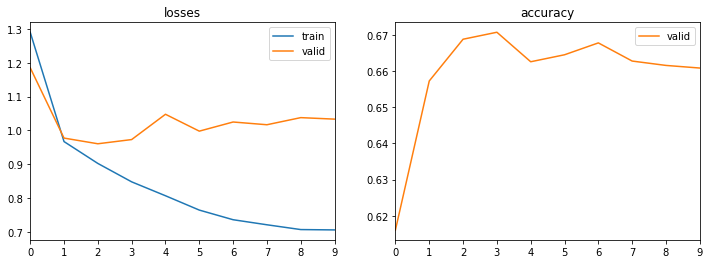

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 50, 'lr': 0.001, 'optimizer': <function RMSProp at 0x0000014B8E61E1F8>, 'patience': 5, 'time_steps': 60}
ResNet                                                                                                                 
 63%|███████████████████████████████                  | 19/30 [33:31<17:58, 98.03s/trial, best loss: 0.937955379486084]

epoch,train_loss,valid_loss,accuracy,time
0,0.957047,0.941487,0.662613,00:06
1,0.873814,0.898501,0.671396,00:06
2,0.829330,1.029396,0.636987,00:06
3,0.789211,1.162805,0.654988,00:06
4,0.751617,1.072483,0.655905,00:06
5,0.702091,1.039817,0.670286,00:06
6,0.653439,1.333359,0.516191,00:06


No improvement since epoch 1: early stopping                                                                           
 63%|███████████████████████████████                  | 19/30 [34:19<17:58, 98.03s/trial, best loss: 0.937955379486084]

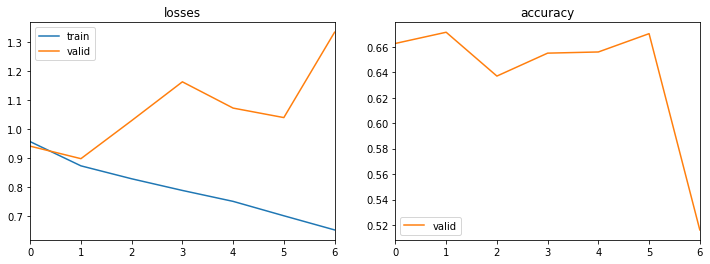

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 100, 'lr': 0.0001, 'optimizer': <function SGD at 0x0000014B8E61E0D8>, 'patience': 5, 'time_steps': 90}
ResNet                                                                                                                 
 67%|████████████████████████████████▋                | 20/30 [34:44<15:04, 90.47s/trial, best loss: 0.937955379486084]

epoch,train_loss,valid_loss,accuracy,time
0,1.737747,1.747200,0.246899,00:08
1,1.727004,1.735252,0.277689,00:08
2,1.712964,1.719880,0.319097,00:09
3,1.695539,1.700026,0.365909,00:09
4,1.673010,1.674864,0.429709,00:09
5,1.643473,1.643775,0.492978,00:09
6,1.608677,1.605036,0.555282,00:09
7,1.566503,1.563075,0.599247,00:09
8,1.522464,1.514265,0.626225,00:09
9,1.476041,1.462978,0.649727,00:09


No improvement since epoch 90: early stopping                                                                          
 67%|████████████████████████████████▋                | 20/30 [50:51<15:04, 90.47s/trial, best loss: 0.937955379486084]

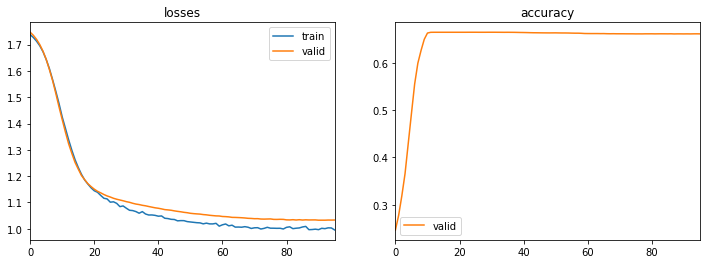

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 100, 'lr': 0.0001, 'optimizer': <function SGD at 0x0000014B8E61E0D8>, 'patience': 5, 'time_steps': 60}
ResNet                                                                                                                 
 70%|█████████████████████████████████▌              | 21/30 [51:17<54:09, 361.07s/trial, best loss: 0.937955379486084]

epoch,train_loss,valid_loss,accuracy,time
0,1.894059,1.874497,0.066213,00:06
1,1.879326,1.857906,0.072776,00:06
2,1.862215,1.839351,0.082284,00:07
3,1.837333,1.813314,0.100767,00:07
4,1.810858,1.780023,0.129820,00:07
5,1.770898,1.736886,0.185319,00:07
6,1.725797,1.684869,0.292940,00:07
7,1.673933,1.630360,0.462381,00:07
8,1.615358,1.566610,0.605280,00:07
9,1.551317,1.502388,0.651609,00:07


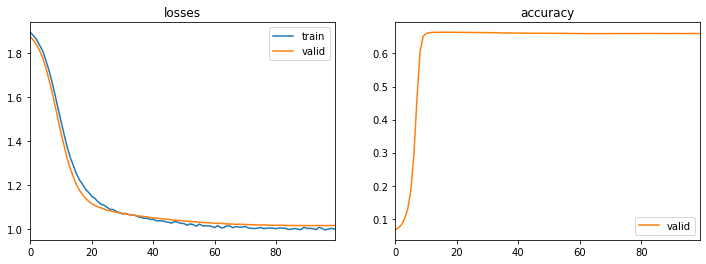

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 100, 'lr': 0.0001, 'optimizer': <function SGD at 0x0000014B8E61E0D8>, 'patience': 5, 'time_steps': 60}
ResNet                                                                                                                 
 73%|████████████████████████████████▎           | 22/30 [1:04:34<1:05:34, 491.84s/trial, best loss: 0.937955379486084]

epoch,train_loss,valid_loss,accuracy,time
0,1.868857,1.896875,0.081994,00:06
1,1.854064,1.881900,0.082766,00:06
2,1.837367,1.865045,0.084262,00:07
3,1.814779,1.836472,0.087448,00:07
4,1.786245,1.803413,0.092997,00:07
5,1.748716,1.761305,0.104918,00:07
6,1.704906,1.713891,0.128179,00:07
7,1.653457,1.657523,0.187443,00:07
8,1.596190,1.594394,0.337966,00:07
9,1.537613,1.530015,0.548767,00:07


No improvement since epoch 81: early stopping                                                                          
 73%|████████████████████████████████▎           | 22/30 [1:15:50<1:05:34, 491.84s/trial, best loss: 0.937955379486084]

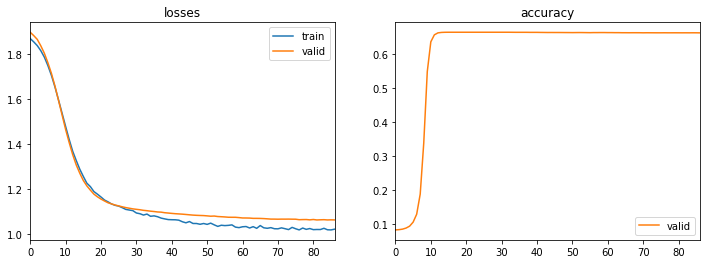

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 100, 'lr': 0.0001, 'optimizer': <function SGD at 0x0000014B8E61E0D8>, 'patience': 5, 'time_steps': 60}
ResNet                                                                                                                 
 77%|█████████████████████████████████▋          | 23/30 [1:16:15<1:04:43, 554.73s/trial, best loss: 0.937955379486084]

epoch,train_loss,valid_loss,accuracy,time
0,2.022294,2.043084,0.096762,00:06
1,2.007393,2.029752,0.099223,00:06
2,1.991206,2.008444,0.099464,00:07
3,1.962636,1.979761,0.105062,00:07
4,1.928958,1.938838,0.112784,00:07
5,1.890912,1.896753,0.125380,00:07
6,1.839433,1.844784,0.143767,00:07
7,1.780845,1.777984,0.179818,00:07
8,1.712401,1.704173,0.265238,00:07
9,1.637730,1.630558,0.390811,00:07


No improvement since epoch 90: early stopping                                                                          
 77%|█████████████████████████████████▋          | 23/30 [1:28:46<1:04:43, 554.73s/trial, best loss: 0.937955379486084]

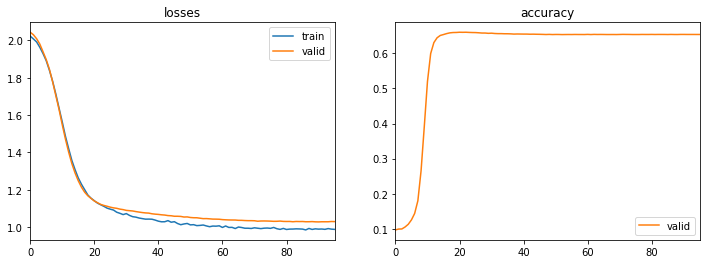

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 100, 'lr': 0.001, 'optimizer': <function SGD at 0x0000014B8E61E0D8>, 'patience': 5, 'time_steps': 90}
ResNet                                                                                                                 
 80%|███████████████████████████████████▏        | 24/30 [1:29:12<1:02:07, 621.23s/trial, best loss: 0.937955379486084]

epoch,train_loss,valid_loss,accuracy,time
0,1.712654,1.695573,0.260460,00:09
1,1.620829,1.591532,0.514357,00:09
2,1.524952,1.482522,0.611602,00:10
3,1.424325,1.377882,0.654505,00:10
4,1.336345,1.287207,0.662854,00:10
5,1.260617,1.214268,0.664205,00:10
6,1.196991,1.166764,0.663868,00:10
7,1.154395,1.136373,0.663144,00:10
8,1.121064,1.118163,0.663337,00:10
9,1.097144,1.106601,0.663144,00:10


No improvement since epoch 71: early stopping                                                                          
 80%|███████████████████████████████████▏        | 24/30 [1:46:03<1:02:07, 621.23s/trial, best loss: 0.937955379486084]

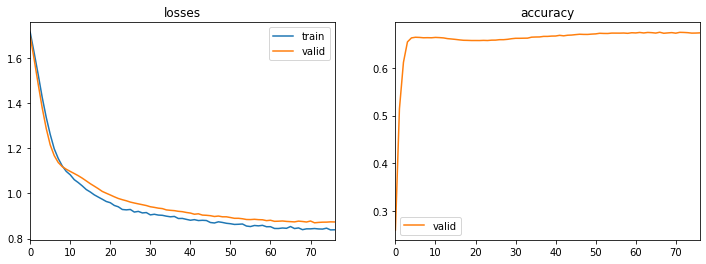

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 100, 'lr': 0.001, 'optimizer': <function SGD at 0x0000014B8E61E0D8>, 'patience': 5, 'time_steps': 90}
ResNet                                                                                                                 
 83%|███████████████████████████████████▊       | 25/30 [1:46:33<1:02:10, 746.06s/trial, best loss: 0.8733463287353516]

epoch,train_loss,valid_loss,accuracy,time
0,1.778247,1.754174,0.196612,00:09
1,1.671639,1.634992,0.475170,00:09
2,1.558562,1.509663,0.586651,00:09
3,1.443324,1.388811,0.645239,00:09
4,1.340742,1.284770,0.661406,00:09
5,1.264232,1.204898,0.663771,00:10
6,1.200490,1.153831,0.664447,00:10
7,1.158348,1.123019,0.664543,00:10
8,1.128309,1.104747,0.664543,00:10
9,1.106670,1.091979,0.664543,00:10


No improvement since epoch 70: early stopping                                                                          
 83%|███████████████████████████████████▊       | 25/30 [2:00:10<1:02:10, 746.06s/trial, best loss: 0.8733463287353516]

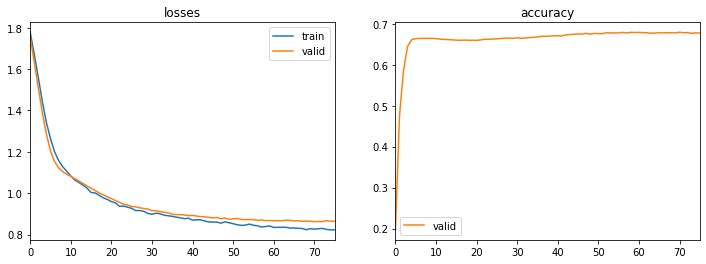

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 100, 'lr': 0.001, 'optimizer': <function SGD at 0x0000014B8E61E0D8>, 'patience': 5, 'time_steps': 90}
ResNet                                                                                                                 
 87%|███████████████████████████████████████      | 26/30 [2:00:38<51:44, 776.10s/trial, best loss: 0.8644011616706848]

epoch,train_loss,valid_loss,accuracy,time
0,1.572306,1.537709,0.634718,00:09
1,1.493871,1.456652,0.653395,00:09
2,1.422201,1.378170,0.660827,00:10
3,1.344973,1.302823,0.663192,00:10
4,1.280984,1.238691,0.664302,00:10
5,1.227863,1.190290,0.664543,00:10
6,1.187011,1.157341,0.664543,00:10
7,1.152727,1.135110,0.664543,00:10
8,1.130572,1.119804,0.664543,00:10
9,1.103400,1.108072,0.664543,00:10


No improvement since epoch 77: early stopping                                                                          
 87%|███████████████████████████████████████      | 26/30 [2:15:43<51:44, 776.10s/trial, best loss: 0.8644011616706848]

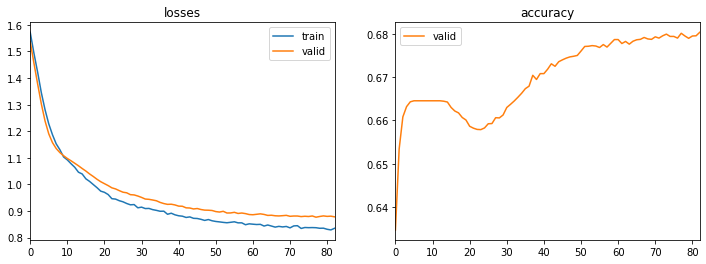

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 100, 'lr': 0.001, 'optimizer': <function SGD at 0x0000014B8E61E0D8>, 'patience': 5, 'time_steps': 90}
ResNet                                                                                                                 
 90%|████████████████████████████████████████▌    | 27/30 [2:16:13<41:09, 823.27s/trial, best loss: 0.8644011616706848]

epoch,train_loss,valid_loss,accuracy,time
0,1.760116,1.734697,0.123980,00:09
1,1.656213,1.619024,0.345012,00:09
2,1.548463,1.502659,0.623474,00:09
3,1.437779,1.387194,0.664157,00:10
4,1.339781,1.289939,0.664495,00:10
5,1.263396,1.217526,0.664543,00:10
6,1.206566,1.171559,0.664495,00:10
7,1.166359,1.139990,0.664350,00:10
8,1.142614,1.121463,0.664157,00:10
9,1.115702,1.109042,0.663964,00:10


No improvement since epoch 67: early stopping                                                                          
 90%|████████████████████████████████████████▌    | 27/30 [2:29:27<41:09, 823.27s/trial, best loss: 0.8644011616706848]

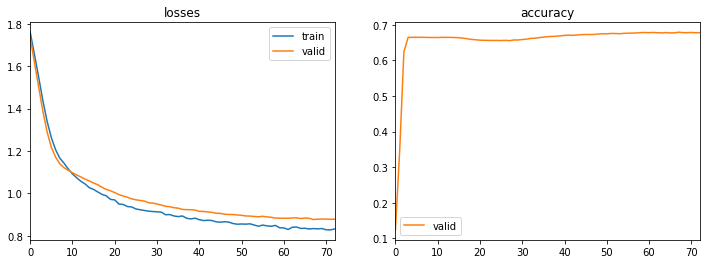

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 100, 'lr': 0.001, 'optimizer': <function SGD at 0x0000014B8E61E0D8>, 'patience': 5, 'time_steps': 90}
ResNet                                                                                                                 
 93%|██████████████████████████████████████████   | 28/30 [2:29:56<27:27, 823.59s/trial, best loss: 0.8644011616706848]

epoch,train_loss,valid_loss,accuracy,time
0,1.513205,1.483760,0.571980,00:09
1,1.449397,1.413819,0.651996,00:09
2,1.377442,1.340830,0.658221,00:09
3,1.309338,1.270610,0.662758,00:10
4,1.242748,1.209245,0.663916,00:10
5,1.190131,1.162281,0.664447,00:10
6,1.154879,1.130790,0.664784,00:10
7,1.122883,1.111022,0.664591,00:10
8,1.100150,1.098203,0.664157,00:10
9,1.078718,1.089004,0.663578,00:10


No improvement since epoch 85: early stopping                                                                          
 93%|██████████████████████████████████████████   | 28/30 [2:46:27<27:27, 823.59s/trial, best loss: 0.8644011616706848]

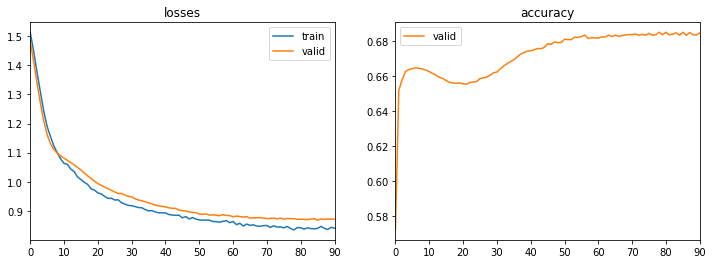

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 100, 'lr': 0.001, 'optimizer': <function SGD at 0x0000014B8E61E0D8>, 'patience': 5, 'time_steps': 90}
ResNet                                                                                                                 
 97%|███████████████████████████████████████████▌ | 29/30 [2:46:56<14:42, 882.41s/trial, best loss: 0.8644011616706848]

epoch,train_loss,valid_loss,accuracy,time
0,1.656611,1.616219,0.460258,00:09
1,1.584386,1.541652,0.563583,00:09
2,1.508159,1.459102,0.640992,00:09
3,1.425963,1.373759,0.663047,00:10
4,1.340050,1.294145,0.664543,00:10
5,1.268497,1.224630,0.664543,00:10
6,1.207133,1.170878,0.664543,00:10
7,1.156667,1.132870,0.664543,00:10
8,1.125196,1.105064,0.664543,00:10
9,1.100538,1.088943,0.664591,00:10


No improvement since epoch 74: early stopping                                                                          
 97%|███████████████████████████████████████████▌ | 29/30 [3:01:23<14:42, 882.41s/trial, best loss: 0.8644011616706848]

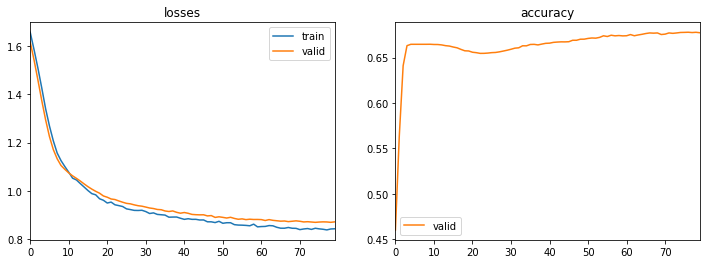

100%|█████████████████████████████████████████████| 30/30 [3:01:23<00:00, 362.79s/trial, best loss: 0.8644011616706848]


In [34]:
trials = Trials()
best = fmin(create_model_hypopt,
    space=search_space,
    algo=tpe.suggest,
    max_evals=30,  # test trials
    trials=trials)

In [35]:
print(best)

{'bs': 1, 'epochs': 2, 'lr': 2, 'optimizer': 1, 'patience': 0, 'ts': 2}


In [36]:
from hyperopt import space_eval

In [37]:
print("Best parameters:")
print(space_eval(search_space, best))

Best parameters:
{'batch_size': 512, 'epochs': 100, 'lr': 0.001, 'optimizer': <function SGD at 0x0000014B8E61E0D8>, 'patience': 5, 'time_steps': 90}


In [38]:
best_parameters = space_eval(search_space, best)

In [39]:
def build_model(params):
    # clear memory 
    gc.collect()
    print("Trying params:",params)
    batch_size = params["batch_size"]
    time_steps = params["time_steps"]
    
    # Create data loader
    tfms  = [None, [Categorize()]]
    dsets = TSDatasets(X[:, :, -time_steps:], y, tfms=tfms, splits=splits, inplace=True)
    # set num_workers for memory bottleneck
    dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
    # Create model
    arch = ResNet
    k = {}
    model = create_model(arch, dls=dls, **k)
    print(model.__class__.__name__)
    
    # Training the model
    learn = Learner(dls, model, metrics=accuracy, opt_func=params['optimizer'])
    start = time.time()
    learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                        cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
    learn.plot_metrics()
    elapsed = time.time() - start
    
    # delete tmp variables
    del dls
    del model
    return learn

Trying params: {'batch_size': 512, 'epochs': 100, 'lr': 0.001, 'optimizer': <function SGD at 0x0000014B8E61E0D8>, 'patience': 5, 'time_steps': 90}
ResNet


epoch,train_loss,valid_loss,accuracy,time
0,1.693848,1.692394,0.116693,00:09
1,1.595999,1.585565,0.367067,00:09
2,1.490437,1.472859,0.606004,00:10
3,1.380779,1.362983,0.654746,00:10
4,1.293028,1.271209,0.662468,00:10
5,1.223186,1.201278,0.664302,00:10
6,1.168830,1.159935,0.664543,00:10
7,1.134537,1.135843,0.664543,00:10
8,1.109286,1.122422,0.664543,00:10
9,1.095178,1.111717,0.664495,00:10


No improvement since epoch 65: early stopping


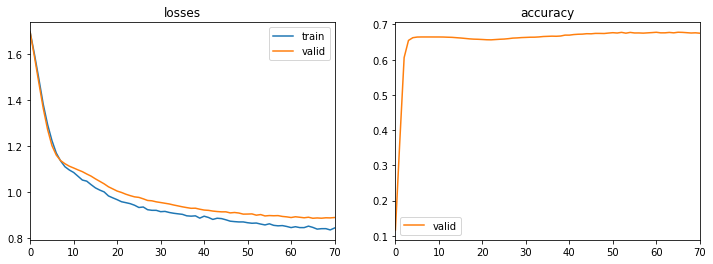

In [40]:
learn = build_model(best_parameters)

In [41]:
dls = learn.dls
valid_dl = dls.valid

In [42]:
time_steps = best_parameters["time_steps"]
X_test_tmp = X_test[:, :, -time_steps:]

In [43]:
test_ds = valid_dl.dataset.add_test(X_test_tmp, y_test)  # use the test data
test_dl = valid_dl.new(test_ds)
print(test_dl.n)

102430


In [44]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
test_probas, test_targets, test_preds

(tensor([[6.3451e-01, 1.8734e-01, 9.4752e-02, 6.1034e-02, 1.8167e-02, 4.1930e-03],
         [9.3329e-01, 4.5362e-02, 1.6156e-02, 2.9181e-03, 1.5951e-03, 6.7463e-04],
         [9.9217e-01, 6.4452e-03, 1.0977e-03, 2.2244e-04, 4.4142e-05, 1.8774e-05],
         ...,
         [9.7821e-01, 1.8265e-02, 2.8009e-03, 4.4917e-04, 1.8004e-04, 9.6595e-05],
         [9.8973e-01, 8.5201e-03, 1.3808e-03, 2.5711e-04, 7.7667e-05, 3.2020e-05],
         [7.5564e-01, 1.4697e-01, 6.1873e-02, 2.4509e-02, 7.4859e-03, 3.5254e-03]]),
 TensorCategory([1, 0, 0,  ..., 0, 0, 0], dtype=torch.int32),
 tensor([0, 0, 0,  ..., 0, 0, 0]))

In [45]:
print(f'accuracy: {skm.accuracy_score(test_targets, test_preds):10.6f}')
print(f'f1 score: {skm.f1_score(test_targets, test_preds, average="weighted"):10.6f}')

accuracy:   0.724671
f1 score:   0.676211


Save the true and predicted results:

In [46]:
y_test_true = test_targets.numpy()
y_test_pred = test_preds.numpy()

In [47]:
np.save('y_true_ResNet', y_test_true)
np.save('y_pred_ResNet', y_test_pred)